In [127]:
import os
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow import keras
import matplotlib.pyplot as plt

In [128]:
# Specify Model
reduced = True
model_type = 'keras' # keras or h5 or onnx
factor_index = 0

# Load Model    

In [129]:
# Load the model
model_url = '../models/fitmotion_model'
if reduced:
    model_url += '_reduced'

if model_type == 'keras':
    model = keras.models.load_model(model_url + '.keras')
elif model_type == 'h5':
    model = tf.keras.models.load_model(model_url + '.h5')
elif model_type == 'onnx':
    import onnx
    import onnxruntime as ort
    sess = ort.InferenceSession(model_url + '.onnx')


labels = ['dws', 'jog', 'sit', 'std', 'ups', 'wlk']

# Loading The Data

### Native Android Data

In [130]:
# Load Android Data
data_source = 'android_data_latest'
if reduced:
    data_source += '_reduced'
data_type = 'wlk'
data_num = '1'
data_url = '../data/' + data_source + '/' + data_type + '/' + data_type + data_num + '-SensorData.csv'

df = pd.read_csv(data_url, sep=',')
    
df = df.drop(['Unnamed: 0'], axis=1) if 'Unnamed: 0' in df.columns else df
df = df.drop(['id'], axis=1) if 'id' in df.columns else df
df

,Gravity X,Gravity Y,Gravity Z,User Acceleration X,User Acceleration Y,User Acceleration Z
0,-7.621599,-2.219717,5.757993,-4.823378,-2.148202,-8.000753
1,-7.990885,-2.390984,5.157455,0.396557,-4.395077,-6.016367
2,-8.297370,-2.581800,4.545146,3.260048,-5.152364,-5.159850
3,-8.540878,-2.790551,3.928944,0.280963,-5.523009,-6.095089
4,-8.710469,-3.028502,3.335612,1.393869,-3.125490,-2.825042
...,...,...,...,...,...,...
1056,0.044828,-9.600049,2.001859,0.185090,-0.557045,0.811931
1057,0.034970,-9.597095,2.016176,-0.494582,-0.124255,0.404966
1058,0.013579,-9.592072,2.040189,-0.200251,-0.282507,0.304338
1059,-0.002335,-9.587220,2.062904,-0.179549,-0.186802,0.147548


### Web Data

In [131]:
# # Load Android Data
# data_source = 'html_data_reduced' if reduced else 'html_data'
# device_source = 'iphone'
# data_type = 'sit'
# data_num = '1'

# data_url = '../data/' + data_source + '/' + device_source + '/' + data_type + '/' + data_type + '_' + data_num + '.csv'

# df = pd.read_csv(data_url, sep=',')
# df = df.drop(['Unnamed: 0'], axis=1) if 'Unnamed: 0' in df.columns else df
# df = df.drop(['id'], axis=1) if 'id' in df.columns else df
# df = df.drop(['Timestamp'], axis=1) if 'Timestamp' in df.columns else df
# df

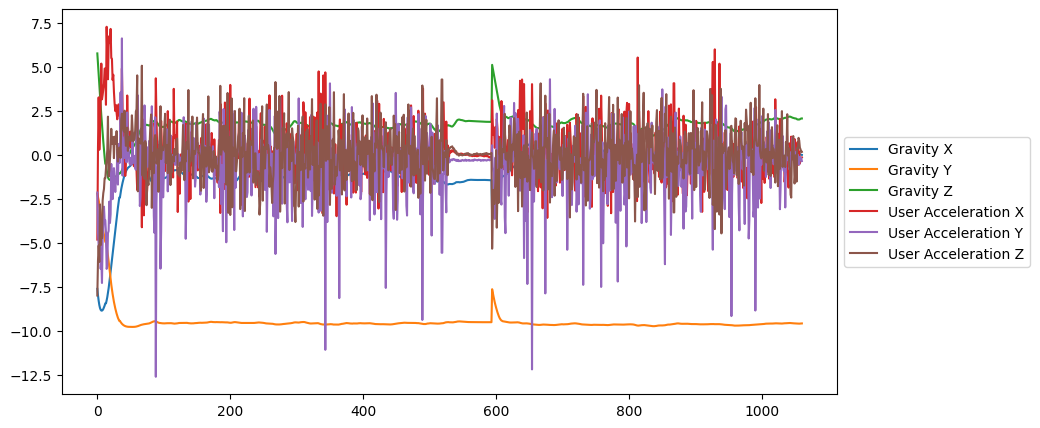

In [132]:
# Check Data by Plotting
plt.figure(figsize=(10, 5))
plt.plot(df)
plt.legend(df.columns, loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [133]:
# Remove Noise Data
df = df.iloc[100:]

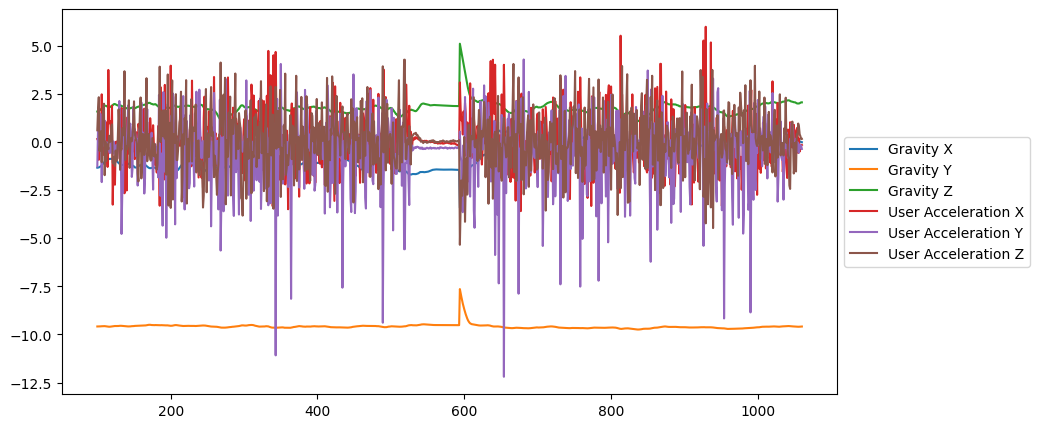

In [134]:
# Check Data by Plotting
plt.figure(figsize=(10, 5))
plt.plot(df)
plt.legend(df.columns, loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

### Original Data

In [135]:
# Load Orignal Data (for comparison)
data_source_o = 'dataset'
if reduced:
    data_source_o += '_reduced'
data_type_o = 'wlk_7'
data_num_o = '4'
data_url_o = '../data/' + data_source_o + '/' + data_type_o + '/' + 'sub_' + data_num_o + '.csv'

df_o = pd.read_csv(data_url_o)
df_o = df_o.drop(['Unnamed: 0'], axis=1) if 'Unnamed: 0' in df_o.columns else df_o
df_o

,gravity.x,gravity.y,gravity.z,userAcceleration.x,userAcceleration.y,userAcceleration.z
0,-0.121138,0.974452,-0.189103,-0.779741,0.495672,0.594301
1,-0.138265,0.977835,-0.157201,-0.416377,0.541651,0.354757
2,-0.146117,0.978342,-0.146581,-0.162065,0.567739,-0.526576
3,-0.155590,0.978078,-0.138367,-0.059711,-0.361272,0.916244
4,-0.161848,0.980369,-0.112564,0.075652,-0.448585,0.873779
...,...,...,...,...,...,...
6466,0.061636,0.984852,0.161966,0.076166,-0.070347,0.081533
6467,0.058643,0.982137,0.178694,0.105572,-0.046499,0.047472
6468,0.052053,0.979115,0.196437,0.133692,0.118724,-0.085262
6469,0.043079,0.975567,0.215352,0.171902,0.122944,-0.341450


# Data Cleaning

In [136]:
# Removing Outliers from Data
def remove_outliers(df):
    result = df.copy()
    for feature in df.columns:
        if pd.api.types.is_numeric_dtype(df[feature]):
            Q1 = df[feature].quantile(0.25)
            Q3 = df[feature].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            result = result[(result[feature] >= lower_bound) & (result[feature] <= upper_bound)]
    return result

df = remove_outliers(df)

In [137]:
# opening scaling factor file to read the dictionary
constants_url = '../constants_reduced.txt' if reduced else '../constants.txt'

factors = []
with open(constants_url, 'r') as f:
    lines = f.readlines()
    for line in lines:
        factors.append(eval(line))
factors

[{'Gravity X': 0.05391829524771258,
  'Gravity Y': -0.10016194958692945,
  'Gravity Z': 0.0055831649450503755,
  'User Acceleration X': 0.011470845449928734,
  'User Acceleration Y': -0.010506739338576385,
  'User Acceleration Z': -0.00842432607181442}]

In [78]:
# Multiply ALL data with constants
for i in range(len(df.columns)):
    df.iloc[:, i] = df.iloc[:, i] * factors[factor_index][df.columns[i]]

In [88]:
# Multiply only the firsts 3 features (Gravity)
for i in range(3):
    df.iloc[:, i] = df.iloc[:, i] * factors[factor_index][df.columns[i]]

In [141]:
#subtract all data for the column of index 2 by 2
df.iloc[:, 2] = df.iloc[:, 2] - 2

In [139]:
df.iloc[:, 1] = abs(df.iloc[:, 1]) * 0.1

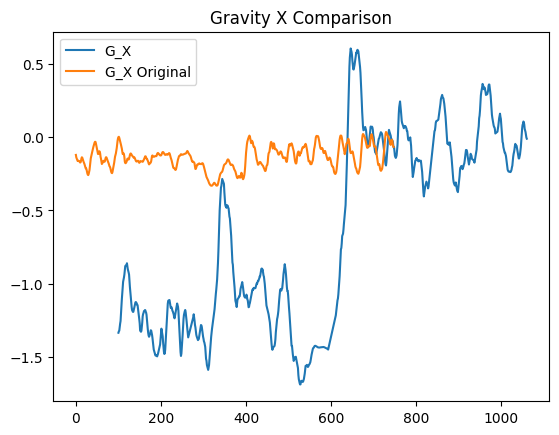

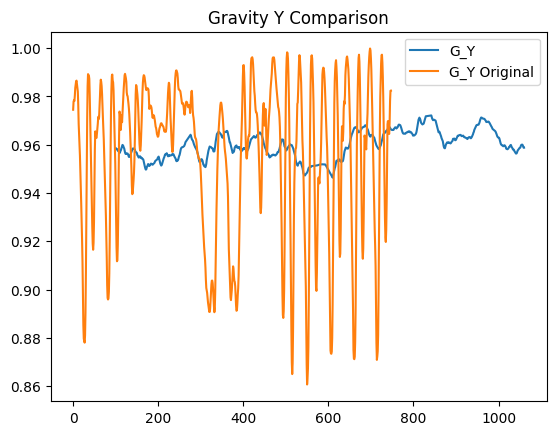

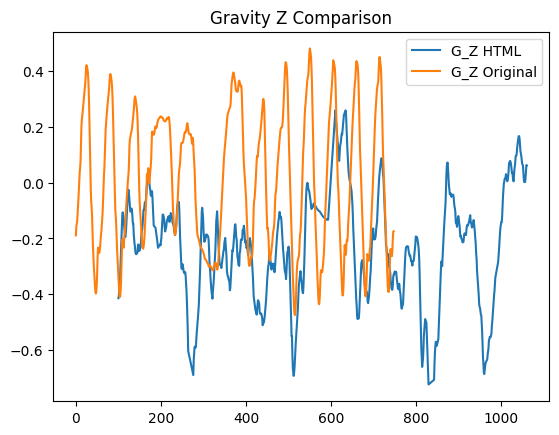

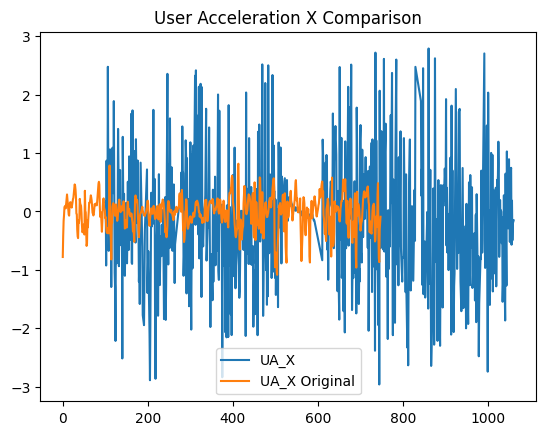

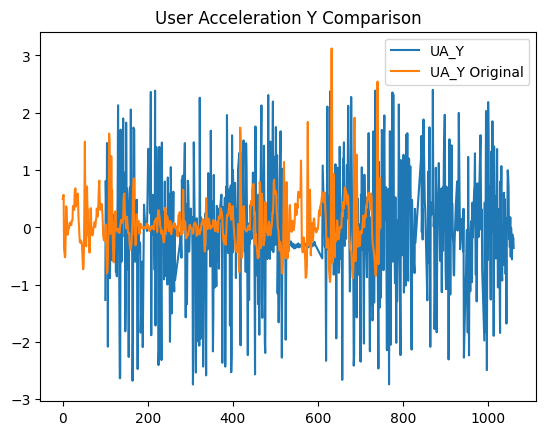

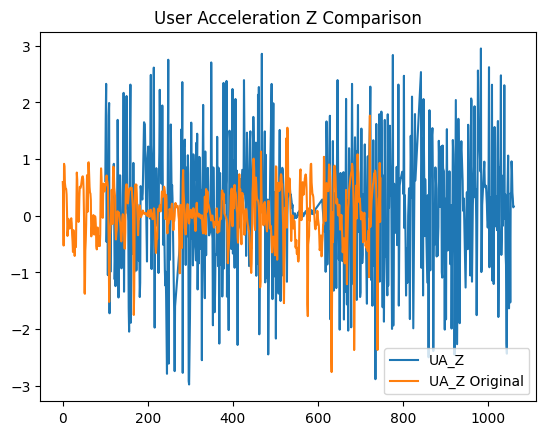

In [142]:
# Check Data Similiraties
plt.title('Gravity X Comparison')
plt.plot(df['Gravity X'], label='G_X')
plt.plot(df_o['gravity.x'].iloc[0:len(df)], label='G_X Original')
plt.legend()
plt.show()

plt.title('Gravity Y Comparison')
plt.plot(df['Gravity Y'], label='G_Y')
plt.plot(df_o['gravity.y'].iloc[0:len(df)], label='G_Y Original')
plt.legend()
plt.show()

plt.title('Gravity Z Comparison')
plt.plot(df['Gravity Z'], label='G_Z HTML')
plt.plot(df_o['gravity.z'].iloc[0:len(df)], label='G_Z Original')
plt.legend()
plt.show()

plt.title('User Acceleration X Comparison')
plt.plot(df['User Acceleration X'], label='UA_X')
plt.plot(df_o['userAcceleration.x'].iloc[0:len(df)], label='UA_X Original')
plt.legend()
plt.show()

plt.title('User Acceleration Y Comparison')
plt.plot(df['User Acceleration Y'], label='UA_Y')
plt.plot(df_o['userAcceleration.y'].iloc[0:len(df)], label='UA_Y Original')
plt.legend()
plt.show()

plt.title('User Acceleration Z Comparison')
plt.plot(df['User Acceleration Z'], label='UA_Z')
plt.plot(df_o['userAcceleration.z'].iloc[0:len(df)], label='UA_Z Original')
plt.legend()
plt.show()

# Preprocessing Data

In [143]:
# Prepare the data
WINDOW_LENGTH = 150
STRIDE_LENGTH = 10
NUM_CLASSES = 6 
NUM_FEATURES = 6 if reduced else 12
BATCH_SIZE = 100
EPOCHS_SIZE = 10

In [144]:
from scipy.stats import mode

def sequence_generator(x, length, stride):
    seq_x = []
    data_length = len(x)

    for i in range(0, data_length - length + 1, stride):
        input_sequence = x.iloc[i : i + length]
        seq_x.append(input_sequence)
    return np.array(seq_x)

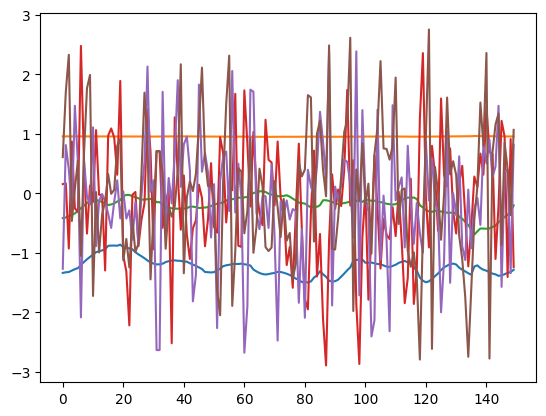

In [145]:
# Checking data
import matplotlib.pyplot as plt

tx = sequence_generator(df, WINDOW_LENGTH, STRIDE_LENGTH)
plt.plot(tx[0])
plt.show()

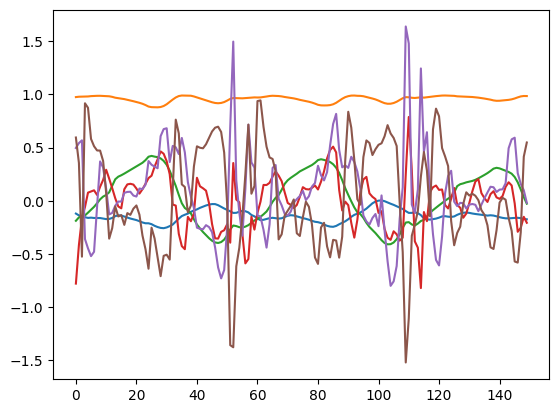

In [146]:
txc = sequence_generator(df_o, WINDOW_LENGTH, STRIDE_LENGTH)
plt.plot(txc[0])
plt.show()

# Prediction

In [147]:
if model_type == 'onnx':
    # Predict with ONNX
    tx = tx.astype(np.float32)
    input_name = sess.get_inputs()[0].name
    output_name = sess.get_outputs()[0].name
    y_pred = sess.run([output_name], {input_name: tx})[0]
    y_pred = np.argmax(y_pred, axis=1)
    y_pred = mode(y_pred)[0]
else: 
    # Predict the data
    y_pred = model.predict(tx)

    # Get the most frequent label
    y_pred = np.argmax(y_pred, axis=1)
    y_pred = mode(y_pred)[0]

print(labels[y_pred])

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
wlk
